# Control Systems Tutorial 
## Part A: Cable car dynamics

### The cable car model
The cable car has four states associated with the slider position and the angle of its suspension cable. The differential equation with states $(\varphi, \omega, x, v)\in [0, 2\pi) \times \mathbb{R}^3$ reads
$$\begin{align*}
M \ddot{x} &=  -\gamma \dot{x} - T(\varphi, \dot{\varphi}, \ddot{x}) \sin \varphi + F_\mathrm{c}\\
m \ddot{\varphi} &= -mg/l \sin \varphi + \cos \varphi \cdot \ddot{x} m
\end{align*}$$
where $v = \dot{x}$, $\omega = \dot{\varphi}$. 
The line tension is $$ T(\varphi, \dot{\varphi}, \ddot{x}) = mg \cos\varphi + m l \dot{\varphi}^2 - m l \ddot{x} \sin \varphi$$

In [133]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
import numpy as np
import matplotlib.pyplot as plt 
import control as ct
import control.optimal as opt
# from scipy.integrate import solve_ivp
from source.cablecar_model import cablecar_ode, cablecar_smallangle_ode, cablecar_output

# System parameters 
M = 100; m = 900; l = 5.0; g = 9.81; gammax = 20.0; gammaphi = 2.0

cablecar_params = {
    "M": M,           # mass of the slider
    "m": m,         # mass of the cable car
    "l": l,         # length of the suspension cable
    "g": g,         # gravitational acceleration
    "gammax": gammax,       # damping of the slider
    "gammaphi": gammaphi,       # damping of the cable car
}

cablecar_sys = ct.nlsys(
    cablecar_ode, cablecar_output, name='cablecar',
    params=cablecar_params, states=['phi', 'omega', 'x', 'v'],
    outputs=['phi', 'omega', 'x', 'v'], inputs=['F'])
cablecar_smallangle_sys = ct.nlsys(
    cablecar_smallangle_ode, cablecar_output, name='cablecar',
    params=cablecar_params, states=['phi', 'omega', 'x', 'v'],
    outputs=['phi', 'omega', 'x', 'v'], inputs=['F'])

### Task 1: Steady states and Phase Portrait
Determine the steady state(s) analytically. For this, set the differential equations to zero and determine if they are stable. 

**Proceed with pen and paper** 

Now, plot the reduced phase-portrait spanned by $(\theta, \omega)$ keeping $x, v$ at zero. Employ `phase_plane_plot` on a self-defined `cablecar_reduced_ode`. How many equilibria are there? 

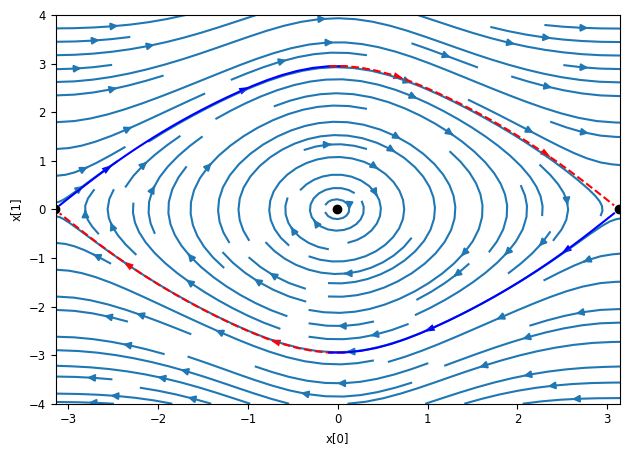

In [ ]:
# define reduced system ode
cablecar_reduced_ode = lambda t, x : cablecar_ode(t, np.concatenate((x,np.array([0.0, 0.0]))), [100.0], cablecar_params)[:2]
# Phase portrait of the reduced system / pendulum 
axis_limits = [-np.pi, np.pi, -4, 4]
ct.phase_plane_plot(cablecar_reduced_ode, axis_limits,  title='') #xlabel=r'$\phi$', ylabel=r'$\omega$',

The control systems toolbox provides various functions which facilitate the analysis. First, the operating point can be derived with `ct.find_operating_point`. Use it to check your analytical solution. 

In [ ]:
# Stable Steady state phase angle (analytical solution)
x0, u0 = [-0.1, 0.0, 0.0, 0.0], [0.0]
xeq, ueq = ct.find_operating_point(cablecar_sys, x0, u0)

Stable steady state at x


### Task 2: Linearised System Dynamics
Linearise the system's equations of motion with `ct.linearize`. Do this at the stable equilibrium point and for zero control action. Then, compare response dynamics for the step function `Ustep` input given below. 

In [ ]:
# Linearisation of the system around the stable steady state
cablecar_sys_linear = ct.linearize(cablecar_sys, xeq, ueq) 

In [223]:
tmax = 100.0 
timepts = np.linspace(0, tmax, int(tmax * 1000))  # time points for simulation
# Input signal Ustep (force) =1 until t=5, then 0
t_step = 1.0; amp_step = 5000.0 
U_step = np.where(timepts <= t_step, amp_step, 0.0)

resp_nonlinear = ct.input_output_response(cablecar_sys, timepts, U_step, xeq, cablecar_params)

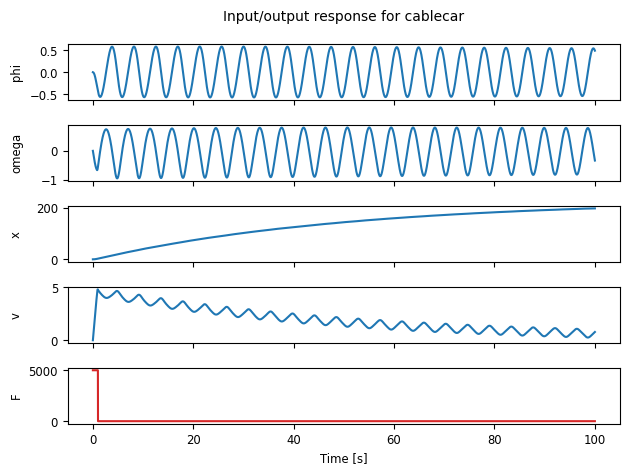

In [224]:
cplt = resp_nonlinear.plot() 

In [225]:
# resp_smallangle = ct.input_output_response(cablecar_smallangle_sys, timepts, U, xeq, cablecar_params)
resp_linear = ct.input_output_response(cablecar_sys_linear, timepts, U_step, xeq, cablecar_params)
resp_nonlinear = ct.input_output_response(cablecar_sys, timepts, U_step, xeq, cablecar_params)

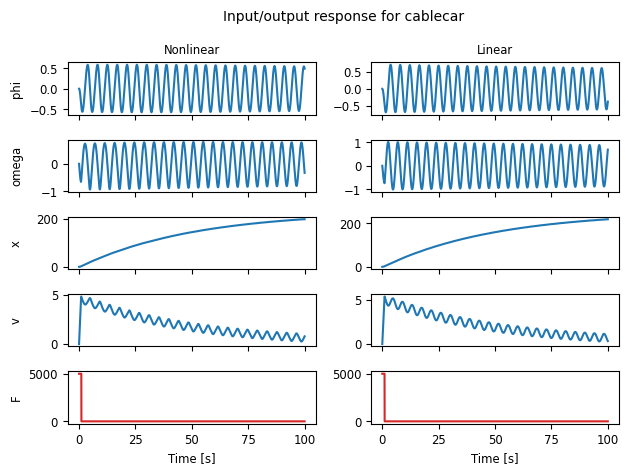

In [228]:
cplt = ct.combine_time_responses([resp_nonlinear, resp_linear], trace_labels=['Nonlinear', 'Linear']) 
cplt.plot()

How is the reduced phase portrait of the linear system different from that of the non-linear system? 

### Task 3: Excitation of system resonance
Today, we want to surprise our cable-car passengers with a dynamical adventure. Excite the cable-car system at its resonance frequency and plot the time-series data. The resonance frequency can be obtained, e.g., with a Bode plot. 

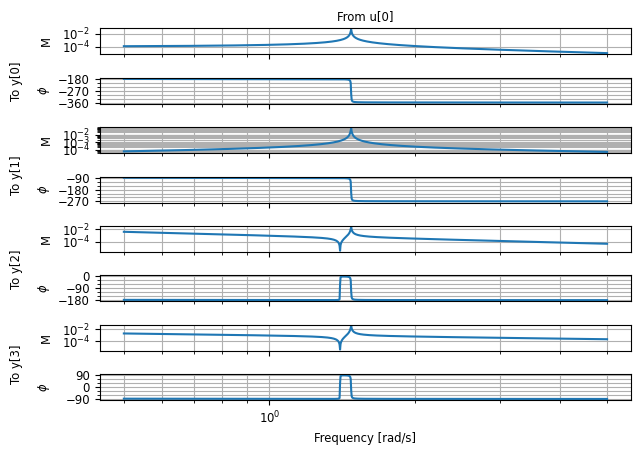

In [242]:
# Plot Bode plot
resp_data = ct.frequency_response(cablecar_sys_linear, omega_limits=(0.5, 5))
ct.bode_plot(resp_data, title="", magnitude_label="M", phase_label=r"$\phi$")

In [184]:
# root locus
ct.damp(cablecar_sys_linear) 

# check eigenvalues of the linearised system
np.linalg.eigvals(cablecar_sys_linear.A) 

    Eigenvalue (pole)       Damping     Frequency
                    0             1             0
 -0.001511    +1.476j      0.001023         1.476
 -0.001511    -1.476j      0.001023         1.476
                -0.02             1          0.02


c:\Users\b.grueger\Nextcloud\events\PhD Retreat 2025\ControlSystems Workshop\.venv\Lib\site-packages\control\lti.py:104: RuntimeWarning: invalid value encountered in divide
  zeta = -real(splane_poles)/wn


array([ 0.        +0.j        , -0.00151092+1.47646709j,
       -0.00151092-1.47646709j, -0.02000039+0.j        ])

In [204]:
### Response analysis
ts = np.linspace(0, 200, 200 * 1000) # time points for simulation
# External Forcing: frequency and amplitude
amp_force = 200.0
freq_force = 1.4 / (2 * np.pi)  # in Hz
input_force = [amp_force * np.sin(2 * np.pi * freq_force * t) for t in ts]
forced_resp = ct.forced_response(cablecar_sys, ts, input_force) 

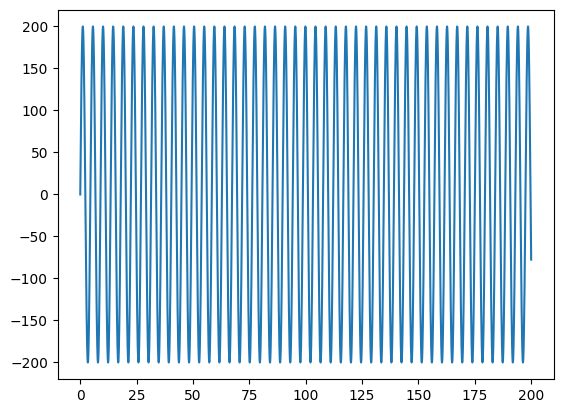

In [205]:
plt.plot(ts, input_force)

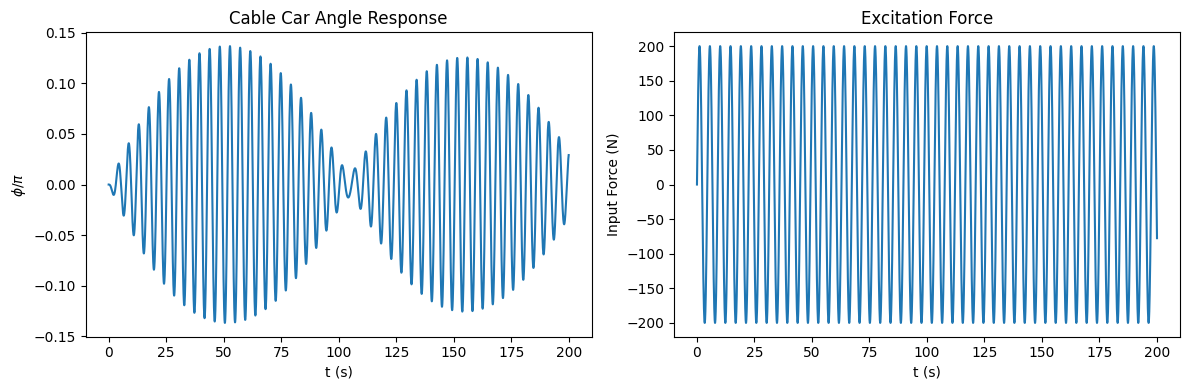

In [206]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(forced_resp.time, forced_resp.states[0] / np.pi)
axs[0].set_xlabel(r't (s)')
axs[0].set_ylabel(r'$\phi / \pi$')
axs[0].set_title('Cable Car Angle Response')

axs[1].plot(ts, input_force)
axs[1].set_xlabel(r't (s)')
axs[1].set_ylabel('Input Force (N)')
axs[1].set_title('Excitation Force')

plt.tight_layout()
plt.show()

### Task 4: Determine the impact of masses on the system 
Investigate the impact of the masses $m$, $M$ on the system stability with a root-locus diagram.

In [255]:
nm= 10
ls_list = np.zeros((4, nm), dtype=complex)  # to store eigenvalues for different masses
for (i, m_c) in enumerate(np.linspace(100, 5000, nm)): 
    cablecar_params_cur = cablecar_params.copy()
    cablecar_params_cur['m'] = m_c  # update mass parameter
    cablecar_sys_cur = ct.nlsys(
    cablecar_ode, cablecar_output, name='cablecar',
    params=cablecar_params_cur, states=['phi', 'omega', 'x', 'v'],
    outputs=['phi', 'omega', 'x', 'v'], inputs=['F'])
    ls = np.linalg.eigvals(ct.linearize(cablecar_sys_cur, xeq, ueq).A) 
    ls_list[:, i] = ls

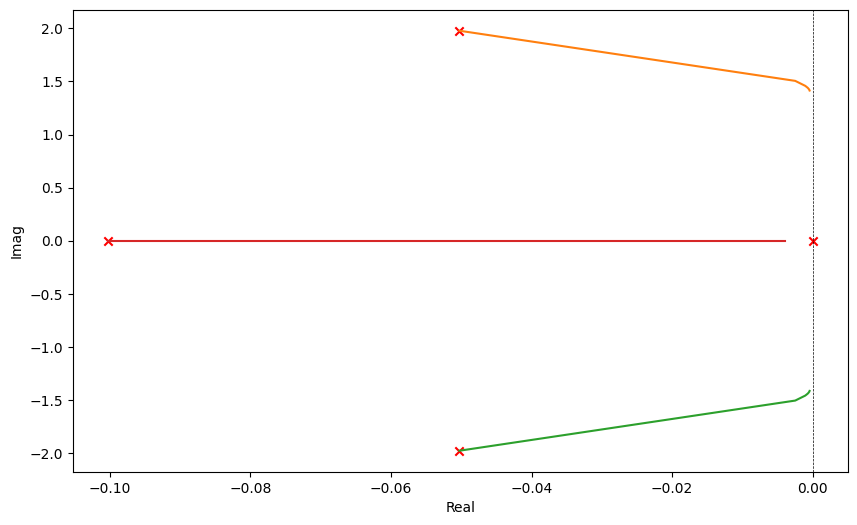

In [256]:
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(ls_list[i,:].real, ls_list[i, :].imag, label=f'Eigenvalue {i+1}')
    # plot initial points
    plt.scatter(ls_list[i, 0].real, ls_list[i, 0].imag, color='red', marker='x')
plt.xlabel('Real')
plt.ylabel('Imag')
# vertical line at 0
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)

In [253]:
nM= 10
ls_list = np.zeros((4, nM), dtype=complex)  # to store eigenvalues for different masses
for (i, M_c) in enumerate(np.linspace(1, 2000, nM)): 
    cablecar_params_cur = cablecar_params.copy()
    cablecar_params_cur['M'] = M_c  # update mass parameter
    cablecar_sys_cur = ct.nlsys(
    cablecar_ode, cablecar_output, name='cablecar',
    params=cablecar_params_cur, states=['phi', 'omega', 'x', 'v'],
    outputs=['phi', 'omega', 'x', 'v'], inputs=['F'])
    ls = np.linalg.eigvals(ct.linearize(cablecar_sys_cur, xeq, ueq).A) 
    ls_list[:, i] = ls

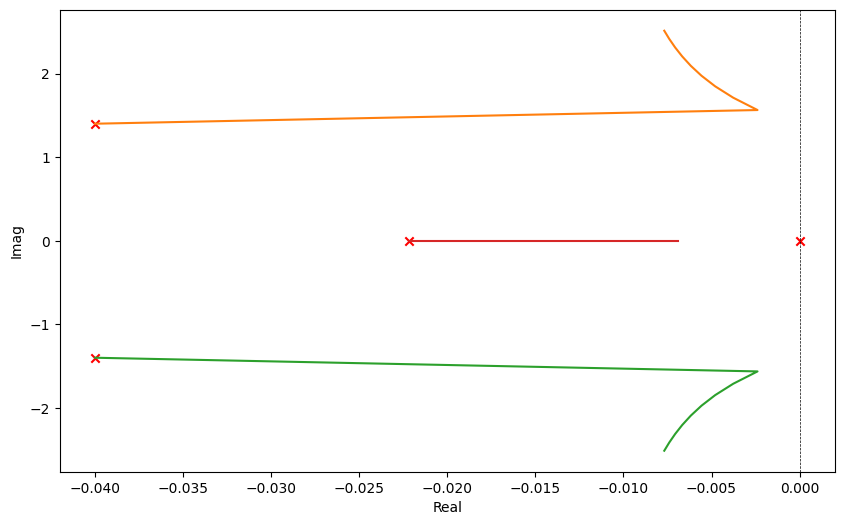

In [254]:
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(ls_list[i,:].real, ls_list[i, :].imag, label=f'Eigenvalue {i+1}')
    # plot initial points
    plt.scatter(ls_list[i, 0].real, ls_list[i, 0].imag, color='red', marker='x')
plt.xlabel('Real')
plt.ylabel('Imag')
# vertical line at 0
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)